COMPUTER VISION LAB 4

GROUP MEMBERS:

Sani Abdullahi Sani - 2770930

Christine Mataranyika - 2770653

Samuel Mba - 2927208

## IMPORT PACKAGES

In [1]:
import cv2
import json
import numpy as np
import imageio.v2 as imageio
from glob import glob
from skimage import img_as_float32
from natsort import natsorted
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import random


C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


## LOAD IMAGES AND MASKS

In [2]:
# Load image and mask paths, ensuring they are sorted by name
image_paths = natsorted(glob('./puzzle_corners_1024x768/images-1024x768/*.png'))
mask_paths = natsorted(glob('./puzzle_corners_1024x768/masks-1024x768/*.png'))

# Ensure we are pairing images with their corresponding masks
path_pairs = list(zip(image_paths, mask_paths))

# Load images and masks as float32 arrays
imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])


## DISPLAY 3 RANDOM IMAGES FOR TESTING

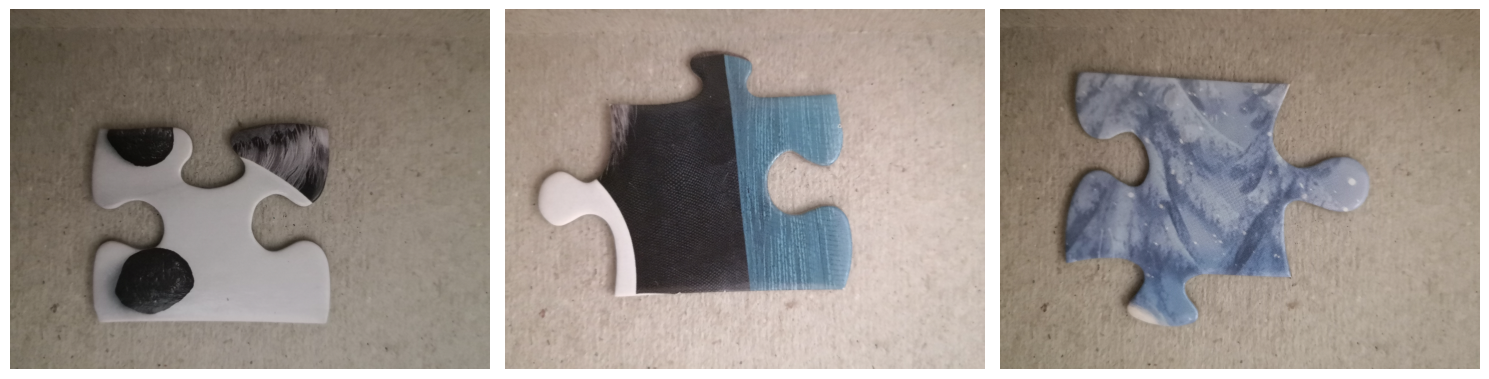

In [3]:
random_indices = np.random.choice(imgs.shape[0], 3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the images in the subplots
for i, idx in enumerate(random_indices):
    axes[i].imshow(imgs[idx])
    axes[i].axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

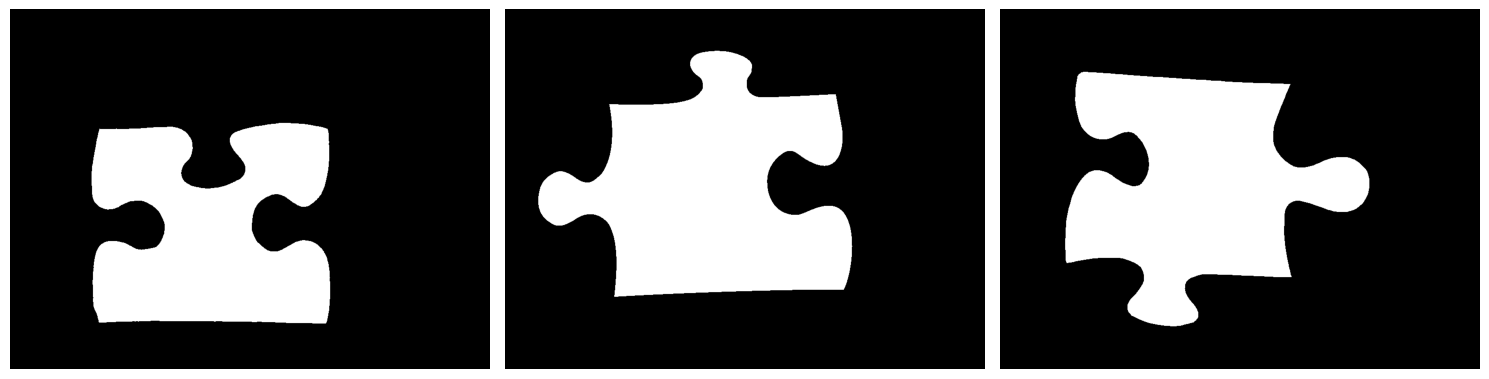

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the images in the subplots
for i, idx in enumerate(random_indices):
    axes[i].imshow(msks[idx] , cmap='gray')
    axes[i].axis('off')  # Hide the axes for better visualization

plt.tight_layout()
plt.show()

## QUESTION 1: FINDING CONTOURS

## Question 1.1

In [5]:
def get_puzzle_contour(mask):
    # Ensure the mask is a binary single-channel (8-bit) image with values 0 and 255
    mask = (mask * 255).astype(np.uint8)
    
    # Find all contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours are found, return None
    if len(contours) == 0:
        return None
    
    # Sort the contours by area in descending order and take the largest one
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Reshape the contour by dropping the middle dimension (from (N, 1, 2) to (N, 2))
    largest_contour = np.squeeze(largest_contour)
    
    return largest_contour

## Question 1.2

In [6]:
def get_clockwise_contour(contour):
    # Check the orientation of the contour using cv2.contourArea with oriented=True
    area = cv2.contourArea(contour, oriented=True)
    
    # If the area is negative, the contour is oriented anti-clockwise and needs to be reversed
    if area < 0:
        contour = contour[::-1]  # Reverse the contour points
    
    # Return the contour ordered clockwise
    return contour


## Orient all contours for later use

In [7]:
def get_oriented_contours(imgs, msks):
    oriented_contours = []  # List to store oriented contours for all images

    for i in range(len(imgs)):
        mask = msks[i]

        # Get the puzzle contour from the mask
        contour = get_puzzle_contour(mask)

        # If a valid contour is found, orient it clockwise
        if contour is not None:
            oriented_contour = get_clockwise_contour(contour)
            oriented_contours.append(oriented_contour)

    # Convert list of contours to a numpy array
    oriented_contours_array = np.array(oriented_contours, dtype=object)  # dtype=object for variable-size contours

    return oriented_contours_array



In [8]:

oriented_contours = get_oriented_contours(imgs, msks)


print(f"Extracted {len(oriented_contours)} oriented contours.")


Extracted 48 oriented contours.


## Question 1.3 

cv2.findContours identifies and extracts boundaries in a binary image, where pixels are either 0 or 255. It operates by scanning the image pixel by pixel, grouping pixels with the same intensity (usually 255, representing the object of interest). The result is represented as an array of (x, y) coordinates that trace the boundary of the detected objects.Contours can be either open, like lines where the start and end points do not meet, or closed, forming complete shapes. The function detects and returns all the contours found in the binary image, regardless of the number of objects or regions present. The output is typically a list, and the mode argument can be used to manage how contour relationships and hierarchies are handled. For example, using cv2.RETR_LIST returns contours as a flat list, treating each contour found separately. cv2.contourArea calculates the area enclosed by a contour. This function is only valid for closed contours; for open contours, the area is 0. The parameter oriented=True allows the calculation of the signed area of the contour. The signed area depends on the ordering of the points that make up the closed contour. If the points are ordered in a counterclockwise direction, the signed area will be positive; if ordered in a clockwise direction, the signed area will be negative.

## Question 1.4 

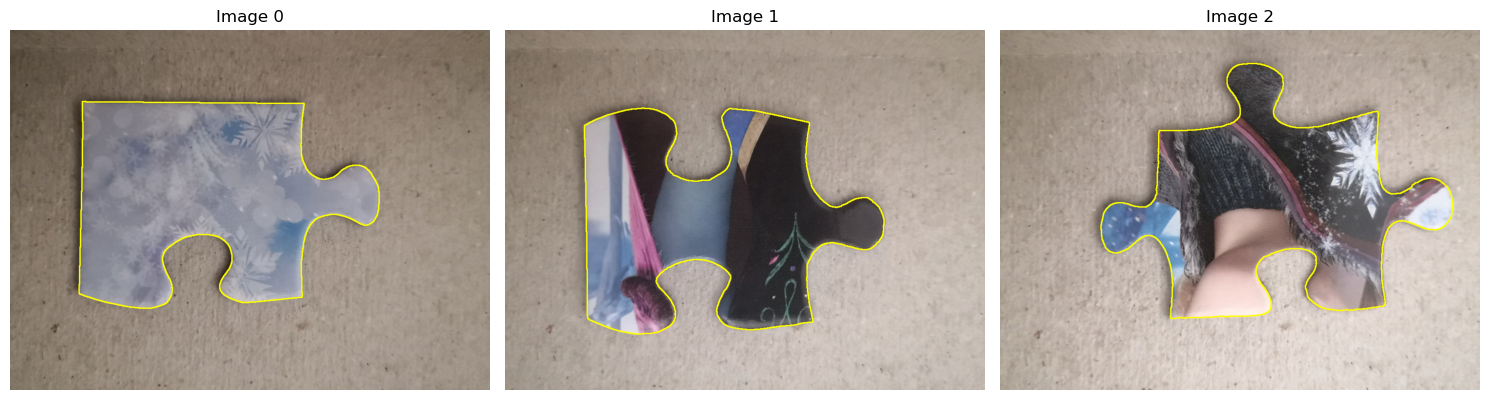

In [9]:
def overlay_contours_on_images(imgs, oriented_contours, indices):

    # Set up a grid for plotting the images
    plt.figure(figsize=(15, 5))  # Adjust size for better visualization

    for i, idx in enumerate(indices):
        img = imgs[idx] * 255  # Scale the image values back to [0, 255]

        # Get the precomputed contour from the list of oriented contours
        contour = oriented_contours[idx]
        if contour is not None:
            # Draw the contour on the image
            cv2.drawContours(img, [contour], -1, (255, 255, 0), 2)  # Yellow contour

        # Plot the image with the contour
        plt.subplot(1, 3, i + 1)  # Plot 3 images in a single row
        plt.imshow(img.astype(np.uint8))  # Ensure image is in the correct format
        plt.axis('off')
        plt.title(f'Image {idx}')

    plt.tight_layout()
    plt.show()

# Example of calling the function with specific indices
indices = [0, 1, 2]  # Indices of the 3 images you want to display
overlay_contours_on_images(imgs, oriented_contours, indices)


## QUESTION 2: SHAPE MODELS 

## Question 2.1 Extract Sides

## Question 2.1.1

In [10]:

with open(".\puzzle_corners_1024x768\corners.json", mode="r") as f:
    names, corner_ratios = json.load(f)

## Question 2.1.2

In [11]:
# Function to extract the four sides of the puzzle piece from oriented contour and corners
def extract_sides(contour, corners, img_shape):
    # Convert corner ratios to pixel coordinates (x, y)
    height, width = img_shape[:2]
    corners_pixels = corners * np.array([width, height])
    
    # Step 1: Find indices of the nearest contour points for each corner
    corner_indices = []
    for corner in corners_pixels:
        corner_dists = np.linalg.norm(contour - corner, axis=-1)
        corner_indices.append(np.argmin(corner_dists))
    
    # Step 2: Sort the corner indices in clockwise order
    corner_indices = sorted(corner_indices)
    
    # Step 3: Extract 4 side contours
    sides = []
    for i in range(4):
        start_idx, end_idx = corner_indices[i], corner_indices[(i + 1) % 4]
        
        # Handle the case where end_idx < start_idx by rolling the contour
        if end_idx < start_idx:
            contour_rolled = np.roll(contour, -start_idx, axis=0)
            side = contour_rolled[:end_idx - start_idx + len(contour)]
        else:
            side = contour[start_idx:end_idx + 1]
        
        sides.append(side)
    
    return sides



## Extracted all sides for later use

In [12]:
def extract_all_sides(imgs, oriented_contours, corner_ratios):

    all_sides = []  # To store sides for each image

    for idx in range(len(imgs)):
        img = imgs[idx] * 255  # Get the RGB image and scale values

        # Get the precomputed contour from the oriented contours array
        contour = oriented_contours[idx]

        # Get the corners for this image from the provided corner ratios
        corners = np.array(corner_ratios[idx])

        # Extract the sides of the puzzle piece using the contour and corners
        sides = extract_sides(contour, corners, img.shape)
        
        # Save the sides for this image
        all_sides.append(sides)

    return all_sides

# Example usage: Extract sides for all images
all_sides = extract_all_sides(imgs, oriented_contours, corner_ratios)


## Question 2.1.3

In [13]:
def plot_puzzle_sides(img, corners, sides):
    # Convert corner ratios to pixel coordinates
    height, width = img.shape[:2]
    corners_pixels = corners * np.array([width, height])
    
    # Plot the original image
    plt.imshow(img)
    
    # Plot the quad formed by the corners in white (255, 255, 255)
    quad_corners = np.vstack([corners_pixels, corners_pixels[0]])  # Close the quad
    plt.plot(quad_corners[:, 0], quad_corners[:, 1], color=(1, 1, 1), linewidth=2)
    
    # Plot the 4 sides in different colors
    colors = [(1, 0, 0), (0, 1, 0), (0, 0.25, 1), (1, 0.75, 0)]  # Red, Green, Blue, Yellow
    for side, color in zip(sides, colors):
        side = np.vstack(side)
        plt.plot(side[:, 0], side[:, 1], color=color, markersize=10, linewidth=2)
    
    plt.axis('off')

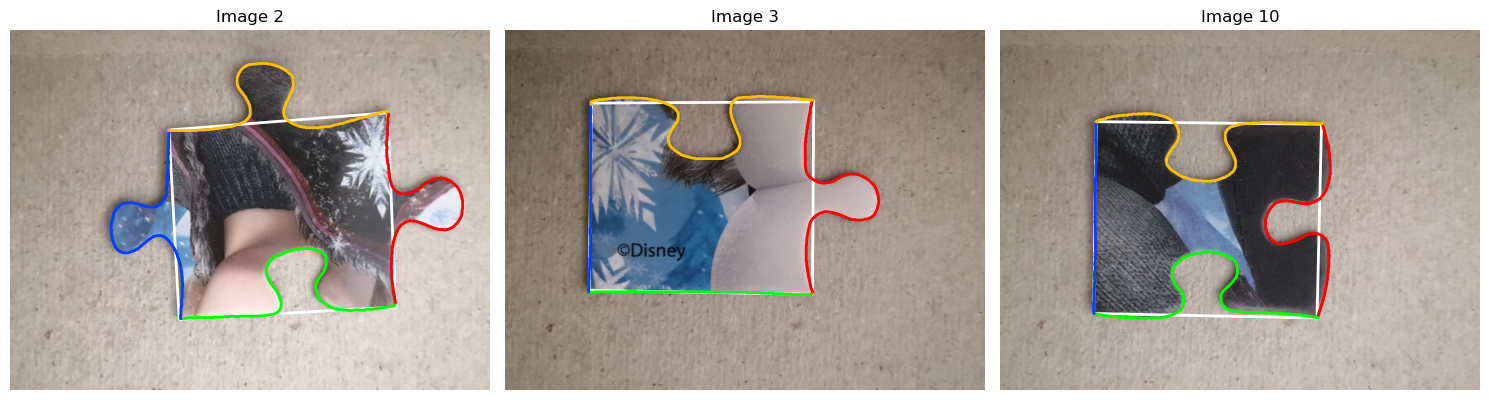

In [14]:
def plot_selected_puzzle_sides(imgs, indices, corner_ratios, all_sides, func):

    # Ensure that indices length is 3
    if len(indices) != 3:
        raise ValueError("Please provide exactly 3 indices.")
    
    plt.figure(figsize=(15, 5))  # Adjust size for better visualization

    for i, idx in enumerate(indices):
        img = imgs[idx] * 255  # Get the RGB image and scale values

        # Get the sides for the current image from the precomputed all_sides list
        sides = all_sides[idx]

        # Get the corners for this image from the provided corner ratios
        corners = np.array(corner_ratios[idx])

        # Plot the results for the current image
        plt.subplot(1, 3, i + 1)  # Plot 3 images side by side
        func(img.astype(np.uint8), corners, sides)  # Convert img to uint8 for plotting
        plt.title(f'Image {idx}')

    plt.tight_layout()
    plt.show()

# Plot sides for 3 selected images
indices = [2, 3, 10]  # Choose indices of 3 images to plot
plot_selected_puzzle_sides(imgs, indices, corner_ratios, all_sides, plot_puzzle_sides)


## Question 2.2: Normalise Sides

## Question 2.2.1

In [15]:
def transform_puzzle_side(contour):

    #contour = contour.reshape(-1, 2)
    start_point = contour[0]
    #print(start_point)
    end_point = contour[-1]
    #print(end_point)

    # Calculate the midpoint between start and end points
    middle_point = (start_point + end_point) / 2
    #print(middle_point)
    
    # Translate by subtracting the midpoint to make the mid point the centre
    translated_contour = contour - middle_point
    #print(translated_contour)
    
    
    
    # Step 2: Scale the contour so that the distance between the first and last points is 2
    distance = np.linalg.norm(start_point - end_point)
    scaling_factor = 2 / distance  # Scale the contour so that the distance is 2 units
    
    scaled_contour = translated_contour * scaling_factor
    #print(scaled_contour)
    
    
    # Step 3: Rotate the contour so that the line from the first to the last point lies on the x-axis
    # Calculate the angle of rotation
    last_point_translated = scaled_contour[0]  # Now the end point after translation and scaling
    angle = np.arctan2(last_point_translated[1], last_point_translated[0])  # Rotation angle
    #print(angle)
    # Rotation matrix to align the line to the x-axis
    rotation_matrix = np.array([[np.cos(-angle), -np.sin(-angle)],
                                [np.sin(-angle), np.cos(-angle)]])
    
    # Apply rotation to the contour
    rotated_contour = scaled_contour @ rotation_matrix.T
    #print(rotated_contour)

    
    if rotated_contour[0][0] > rotated_contour[-1][0]:
    #    # Reverse the contour if the first point is not in the negative x direction
        rotated_contour = rotated_contour[::-1]
        #Flip the y-axis coordinates to actually rotate the contours
        rotated_contour[:, 1] = -rotated_contour[:, 1]
        #print(rotated_contour)

    
    return rotated_contour





In [16]:
#  Transform all sides for later use
def transform_all_sides(all_sides):
    transformed_sides = []
    for side in all_sides:
        for i in range(4):
            transformed = transform_puzzle_side(side[i])
            transformed_sides.append(transformed)
    return transformed_sides


transformed_sides = transform_all_sides(all_sides)


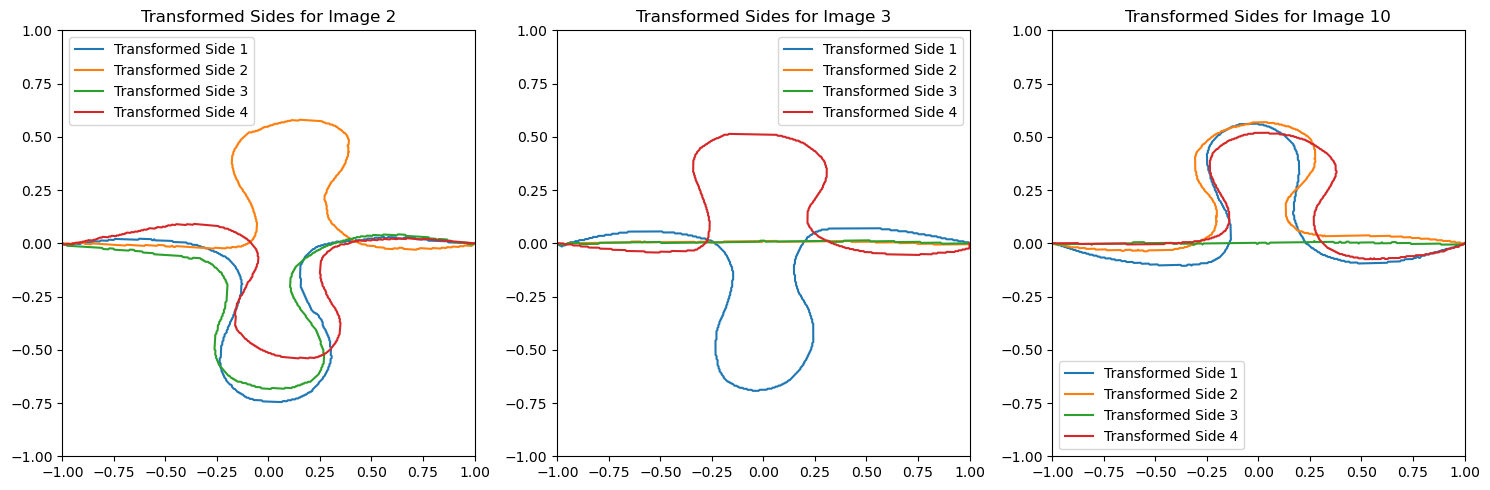

In [17]:
def visualize_transformed_sides(imgs, transformed_sides, indices):
    num_images = len(indices)
    fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

    for i, idx in enumerate(indices):
        img = imgs[idx]

        # Get the transformed sides for the current image
        transformed_sides_for_image = transformed_sides[idx * 4: (idx * 4) + 4]

        # Plot each transformed side on the same axis
        for j, transformed_side in enumerate(transformed_sides_for_image):
            transformed_side = np.array(transformed_side)  # Convert to numpy array if not already
            axes[i].plot(transformed_side[:, 0], transformed_side[:, 1], label=f"Transformed Side {j + 1}")

        axes[i].legend()
        axes[i].set_title(f"Transformed Sides for Image {idx}")

        # Set the x and y axis limits to be between -1 and 1
        axes[i].set_xlim(-1, 1)
        axes[i].set_ylim(-1, 1)

    plt.tight_layout()
    plt.show()

# Example usage
indices = [2, 3, 10]  
visualize_transformed_sides(imgs, transformed_sides, indices)


#For is around the x plane hence only affects y coordinates. Reversing coordinates affects the x plane only. To truly rotate the coordinates there is a need to do both. 

## Question 2.2.2

In [18]:
# Function to generate evenly spaced points on a contour
def even_spaced_contour(contour, num_points=10):
    # Calculate the cumulative distance along the contour
    lengths = np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1))
    total_length = np.sum(lengths)
    cumulative_lengths = np.concatenate(([0], np.cumsum(lengths)))

    # Generate evenly spaced values
    Anew = np.linspace(0, total_length, num_points)

    # Interpolate to get new points
    x_new = np.interp(Anew, cumulative_lengths, contour[:, 0])
    y_new = np.interp(Anew, cumulative_lengths, contour[:, 1])

    # Recombine into new contour
    new_contour = np.column_stack((x_new, y_new))
    return new_contour

## Question 2.2.3

In [19]:
def plot_puzzle_sides_with_even_dots(img, corners, sides, num_white_dots=10):
    # Convert corner ratios to pixel coordinates
    height, width = img.shape[:2]
    corners_pixels = corners * np.array([width, height])
    
    # Plot the original image
    plt.imshow(img)
    
    # Define colors for the sides
    colors = [(1, 0, 0), (0, 1, 0), (0, 0.25, 1), (1, 0.75, 0)]  # Red, Green, Blue, Yellow
    
    for side, color in zip(sides, colors):
        side = np.vstack(side)
        plt.plot(side[:, 0], side[:, 1], color=color, markersize=10, linewidth=2)

        # Mark the start of the contour with a large dot in the same color
        start_point = side[0]  # The starting point of the contour (first point in the side)
        plt.scatter(start_point[0], start_point[1], color=color, s=100, edgecolor='white', zorder=5)  # Large dot

        # Generate evenly spaced points on the contour
        even_points = even_spaced_contour(side, num_white_dots)

        # Plot the evenly spaced white dots
        plt.scatter(even_points[:, 0], even_points[:, 1], color='white', s=20, edgecolor='none', zorder=4)  # Small white dots

    plt.axis('off')


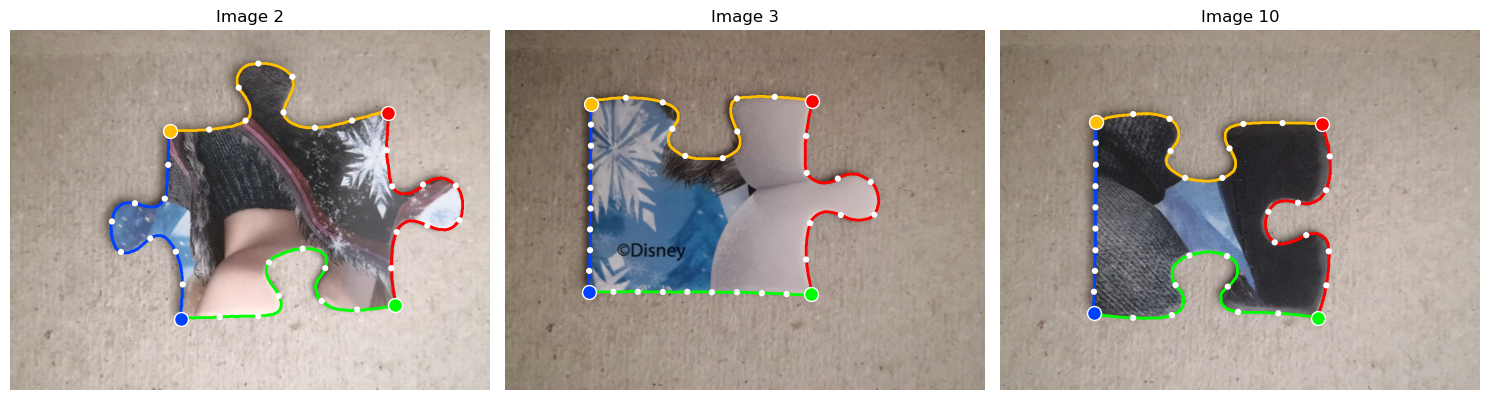

In [20]:
plot_selected_puzzle_sides(imgs, indices, corner_ratios, all_sides, plot_puzzle_sides_with_even_dots)

## QUESTION 3: MATCH SHAPE MODELS 

Normalise for all sides

In [21]:
normalised_sides = []
for side in transformed_sides:
    even_contour = even_spaced_contour(side,num_points=64)
    normalised_sides.append(even_contour)

## Question 3.1

In [22]:
def is_flat_side(contour, min_ratio=0.9):

    contour = contour.astype(np.float32)

    # Calculate the distance between the two endpoints of the contour
    start_point = contour[0]
    end_point = contour[-1]
    cont_dist = np.linalg.norm(end_point - start_point)

    # Calculate the total length of the contour
    cont_len = cv2.arcLength(contour, closed=False)

    # Compute the ratio of endpoint distance to total contour length
    ratio = cont_dist / cont_len

    # Return True if the ratio exceeds the minimum ratio threshold, otherwise False
    return ratio >= min_ratio


Classify the type of side using is_flat_side and the sum of the y-axis coordinates. potruding sides have < 0 and sunken have > 0. 

In [23]:

def puzzle_piece_type(contours, min_ratio=0.9):
    classifications = []  # To store the classification of each side (flat, protruding, or sunken)
    flat_count = 0  # To count the number of flat sides

    for contour in contours:
        # Check if the side is flat using the is_flat_side function
        if is_flat_side(contour, min_ratio):
            classifications.append("flat")
            flat_count += 1
        else:
            # Sum of y-values determines whether it's protruding or sunken
            y_sum = np.sum(contour[:, 1])
            if y_sum < 0:
                classifications.append("protruding")
            else:
                classifications.append("sunken")
    

    return  classifications
        
 


In [24]:
classifications = puzzle_piece_type(normalised_sides, min_ratio=0.9)

## Question 3.2 
#Also got index of pieces with edges for later use

In [25]:
non_flat_sides = []
edge_pieces = []
index_map = [] 

for i, side in enumerate(normalised_sides):
    # Check if the side is not classified as 'flat'
    if classifications[i] != 'flat':
        non_flat_sides.append(side)
        
        # Compute the puzzle piece number and the side number
        puzzle_piece_num = (i // 4)   # Puzzle piece index (1-based)
        side_num = (i % 4) + 1  # Side number (1 to 4)
        
        # Append the tuple (puzzle piece number, side number) to 'indexes'
        index_map.append((puzzle_piece_num, side_num))

    else:
        puzzle_piece_num = (i // 4)   # Puzzle piece index (1-based)
        edge_pieces.append(puzzle_piece_num)

edge_pieces = set(edge_pieces)
        



## Question 3.3

In [26]:


# Rotating and reversing non-flat sides to handle protruding vs sunken sides
rotated_sides = (np.array(non_flat_sides) * (-1, -1))[:, ::-1, :]  # Rotating by 180 degrees

# Flattening the sides into 1D feature vectors
side_features = np.array(non_flat_sides).reshape(len(non_flat_sides), -1)
rotated_side_features = rotated_sides.reshape(len(rotated_sides), -1)

# k-NN for matching protruding and sunken sides
knn = NearestNeighbors(n_neighbors=1, algorithm="brute")
knn.fit(rotated_side_features)
distances, indices = knn.kneighbors(side_features)


## Question 3.4
Used KNN neareast neighbours results as is , connecting nodes using their non-flat-sides nearest neigbour. Results show that not all pieces contours are perfectly aligned, with other pieces having more than the expected matches for its number of flat sides. 

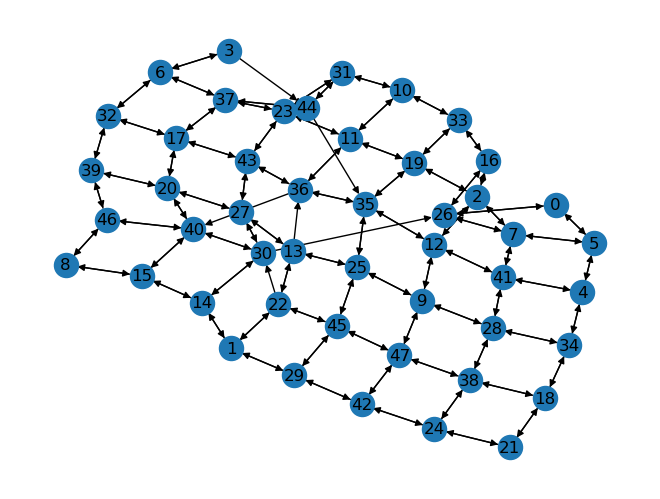

In [27]:
def plot_graph(V, E, seed=42):
    np.random.seed(seed)
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    nx.draw_kamada_kawai(G, with_labels=True)
    pos = nx.spring_layout(G, seed=seed, k=0.5)  # Increase 'k' to spread nodes apart
    plt.show()

# Construct the list of nodes and edges
V = list(range(int(len(transformed_sides)/4)))  # Nodes are the puzzle pieces
E = [(index_map[i][0], index_map[indices[i][0]][0]) for i in range(len(indices))]

# Plot the matching result
plot_graph(V, E)

## Question 3.5

From KNN results only took nodes that have reciprotal matching. Result much cleaner. There are pieces like image 40 that had more than 4 connections and that has been resolved. Though there are now pieces with dont have a match. 

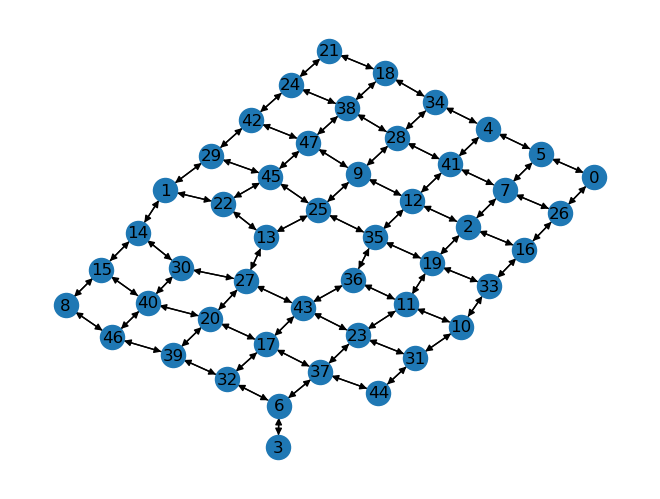

In [28]:
def plot_graph(V, E, seed=42):
    np.random.seed(seed)
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    nx.draw_kamada_kawai(G, with_labels=True)
    pos = nx.spring_layout(G, seed=seed, k=0.5)  # Increase 'k' to spread nodes apart
    plt.show()


# Construct the list of nodes and edges
V = list(range(int(len(transformed_sides)/4)))  # Nodes are the puzzle pieces
E = [(index_map[i][0], index_map[indices[i][0]][0]) for i in range(len(indices))]

matched_edges = [(a, b) for (a, b) in E if (b, a) in E]

# Now matched_edges contains only edges that have a match

# Plot the matching result
plot_graph(V, matched_edges)

## Question 3.6

Only used pieces with at least 1 flat side. List of edge pieces previously computed

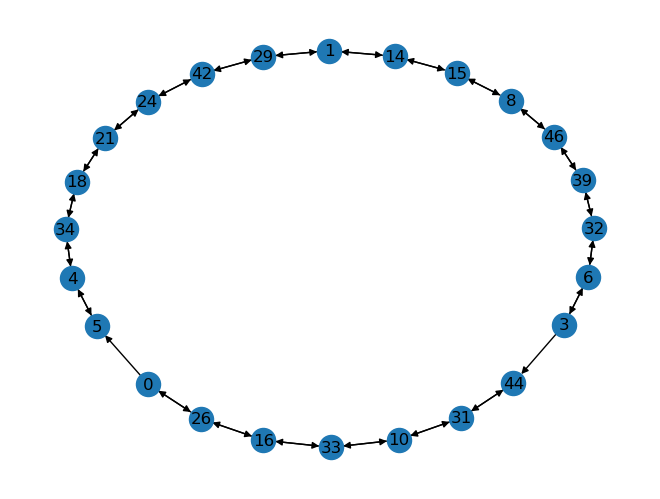

In [29]:
def plot_graph(V, E, seed=42):
    np.random.seed(seed)
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    
    pos = nx.spring_layout(G, seed=seed, k=0.5)  # Calculate positions before drawing
    nx.draw_kamada_kawai(G,  with_labels=True)
    plt.show()

# Construct the list of nodes and edges
V = list(edge_pieces)  # Nodes are the puzzle pieces
E = []  # Initialize an empty list for edges

# Iterate over the index_map
for i, index in enumerate(index_map):  # Use enumerate to get both index and value
    source_node = index[0]  # The node in index_map
    if source_node in edge_pieces:  # Check if the source node is in edge_pieces
        # Get the corresponding node from indices
        corresponding_node = index_map[indices[i][0]][0] if indices[i] and len(indices[i]) > 0 else None
        
        # Only add the edge if the corresponding node is also in edge_pieces
        if corresponding_node is not None and corresponding_node in edge_pieces:
            E.append((source_node, corresponding_node))  # Append edge only if both nodes are in edge_pieces

# Now E will contain edges where both nodes are in edge_pieces
plot_graph(V, E)


## Question 3.7

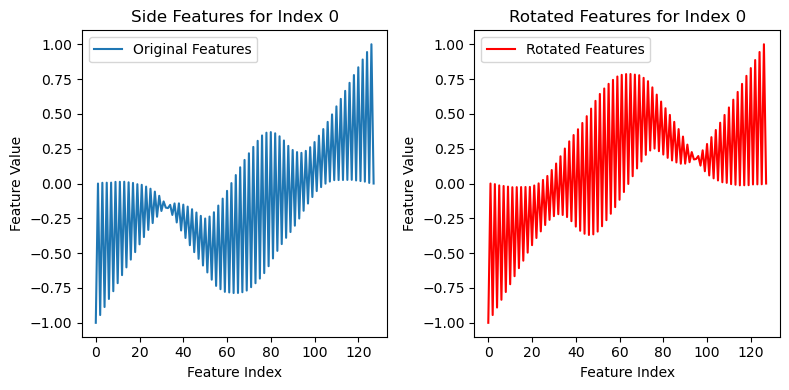

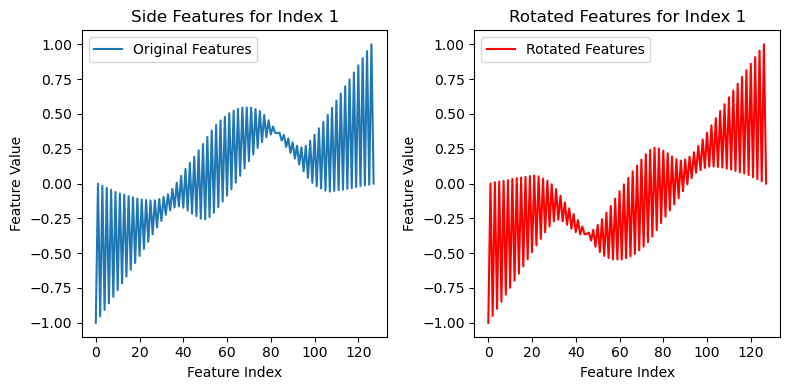

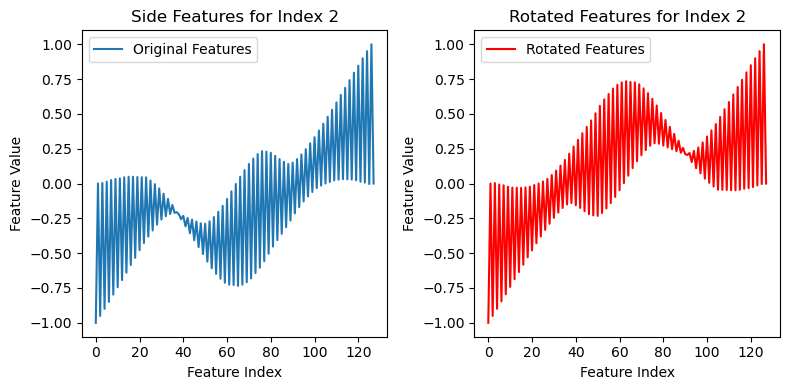

In [30]:

# Plotting side_features and rotated_side_features for each index
for i in range(3):
    plt.figure(figsize=(8, 4))

    # Plot original side features
    plt.subplot(1, 2, 1)
    plt.plot(side_features[i], label='Original Features')
    plt.title(f'Side Features for Index {i}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.legend()

    # Plot rotated side features
    plt.subplot(1, 2, 2)
    plt.plot(rotated_side_features[i], label='Rotated Features', color='r')
    plt.title(f'Rotated Features for Index {i}')
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


Due to human labeling bias, contours obtained from human-labeled masks may also contain inconsistencies and inaccuracies. There is a low probability of obtaining uniform lines, resulting in a distribution of points and slight deviations from the actual contours of puzzle pieces. This variability in the feature representation can lead to errors in matching, particularly due to the potential high similarities in the sides of puzzle pieces. Any small misrepresentation can cause mismatches between puzzle pieces, leading to challenges in accurately solving the puzzle.

To address these issues, further refinement of the masks can be achieved by applying edge detection algorithms, which ensure that the masks accurately represent the actual puzzle pieces. Algorithms such as the Canny edge detector and Sobel operator can enhance edge detection by highlighting significant contours while minimizing noise and irrelevant details. For instance, the Canny edge detector's multi-stage approach provides robust edge localization, making it particularly effective in complex images. Additionally, the Laplacian of Gaussian can help detect edges at various orientations, offering versatility in contour extraction. By employing these edge detection techniques, the integrity of the contours can be improved, ultimately leading to more reliable feature vectors for KNN matching and reducing the likelihood of mismatches in puzzle piece identification.

## Question 3.8

Possible issues are there are a number of transformations that are done on extracted data introducing possible inaccuracies in the data. Also there is an assumption that each sunken / potruding pair is perfectly matched and the expected piece would be the nearest neighbour, which is not always the case as shown by some mismatches.  The way the pieces need to be matched has to be explicitly stated to account for all possible scenarios and get best results. 
For large puzzle pieces there may be possible issues with less perfect alignment between sunken and potruding pieces , due to large pool. Higher chances of not getting the best nearest neighbour. Computationally expensive to enforce all neccessary rules.

## FURTHER WORK

Improvement made on Question 3.5 , adding edge for nodes with no matches back as long as some node sides are not matched

In [31]:
# Rotating and reversing non-flat sides to handle protruding vs sunken sides
rotated_sides = (np.array(non_flat_sides) * (-1, -1))[:, ::-1, :]  # Rotating by 180 degrees

# Flattening the sides into 1D feature vectors
side_features = np.array(non_flat_sides).reshape(len(non_flat_sides), -1)
rotated_side_features = rotated_sides.reshape(len(rotated_sides), -1)

# k-NN for matching protruding and sunken sides
knn = NearestNeighbors(n_neighbors=2, algorithm="brute")
knn.fit(rotated_side_features)
distances, indices = knn.kneighbors(side_features)


# Separating the first and second set of neighbors
first_neighbours = indices[:, 0]  # First set of neighbors
second_neighbours = indices[:, 1]  # Second set of neighbors

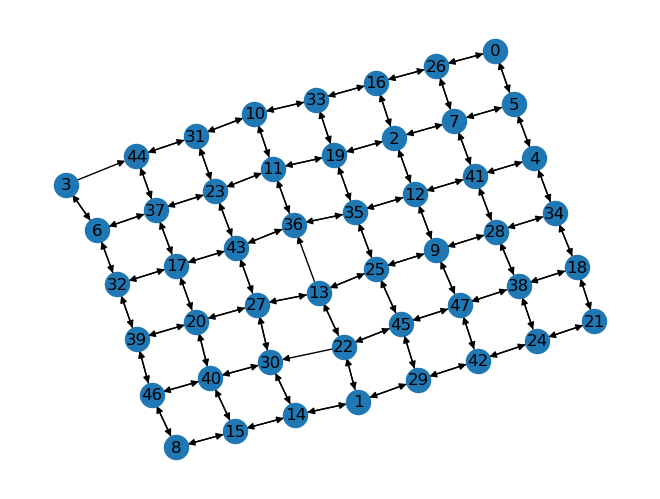

In [32]:

# Function to plot the graph
def plot_graph(V, E, seed=42):
    np.random.seed(seed)
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    nx.draw_kamada_kawai(G, with_labels=True)
    plt.show()

# Initialize lists for edges and nodes
non_flat_sides = []
edge_pieces = []
index_map = []
piece_connections = {}  # To keep track of connections for each piece
max_connections = {}  # Maximum connections based on classification

# Loop over each side and classify as 'flat' or not
for i, side in enumerate(normalised_sides):
    puzzle_piece_num = (i // 4)  # Puzzle piece index (0-based)
    side_num = (i % 4) + 1  # Side number (1 to 4)

    # Initialize connections count for this piece
    piece_connections.setdefault(puzzle_piece_num, 0)

    # Determine max connections based on classification
    max_connections[puzzle_piece_num] = 4 if classifications[i] != 'flat' else 3

    # Check if the side is not classified as 'flat'
    if classifications[i] != 'flat':
        non_flat_sides.append(side)
        index_map.append((puzzle_piece_num, side_num))
    else:
        edge_pieces.append(puzzle_piece_num)

# Mark edge pieces as a set for quick lookups
edge_pieces = set(edge_pieces)

# Create edges based on first neighbors
E = [(index_map[i][0], index_map[indices[i][0]][0]) for i in range(len(indices))]

# Create matched edges (bidirectional connections)
matched_edges = [(a, b) for (a, b) in E if (b, a) in E]

# Initialize piece_connections based on matched edges
for (a, b) in matched_edges:
    piece_connections[a] = piece_connections[a] + 0.5
    piece_connections[b] = piece_connections[b] + 0.5

# Create a list of unmatched edges
unmatched_edges = [(a, b) for (a, b) in E if (b, a) not in matched_edges]

# Check for unmatched edges and add them if nodes have fewer than the required connections
for (a, b) in unmatched_edges:
    if piece_connections[a] < max_connections[a] and piece_connections[b] < max_connections[b]:
        matched_edges.append((a, b))  # Add the unmatched edge as a new match
        piece_connections[a] += 1  # Increment connection count for 'a'
        piece_connections[b] += 1  # Increment connection count for 'b'

# Construct the list of nodes
V = list(range(len(non_flat_sides) // 4))  # Adjust according to the actual number of nodes


# Plot the matched edges
plot_graph(V, matched_edges)